In [4]:
library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(stringr)
library(ggh4x)
library(grid)
library("cowplot")
library(patchwork)
library(ggpubr)

is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  }else{return('black')}
}
my_labeller <- function(x) {
  wrapped <- str_wrap(x, width = 25)
  vapply(wrapped, function(lbl) {
    if (str_count(lbl, "\n") == 0) paste0(lbl, "\n ") else lbl
  }, character(1))
}


In [5]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
#color_annotation$label<-gsub(" cell","",color_annotation$label)
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [6]:
df<-read.csv('01_Freq_Changes_Y1D0_CMV_BRI/Freq_OverTime_CMVpos.csv')

In [7]:
df <- df %>% dplyr::mutate(`Age Group` = case_when(
  cohort.cohortGuid == "BR1" ~ "Young",
  cohort.cohortGuid == "BR2" ~ "Older",
  TRUE ~ NA_character_
))
df$`Age Group`<-factor(df$`Age Group`,levels=c("Young","Older"))

In [8]:
celltype_order <- c(
    "Adaptive NK cell", 
    "KLRF1- GZMB+ CD27- EM CD8 T cell", 
    "KLRF1- GZMB+ CD27- memory CD4 T cell", 
    "KLRF1+ GZMB+ CD27- EM CD8 T cell",
    "KLRF1+ effector Vd1 gdT", 
     "KLRF1- effector Vd1 gdT"
)

In [6]:
#celltype_order<-gsub(" cell","",celltype_order)

In [7]:
#df_sub$AIFI_L3<-gsub(" cell","",df_sub$AIFI_L3)

In [10]:
write.csv(df %>% select(AIFI_L3,subject.subjectGuid,`Age Group`,sample.daysSinceFirstVisit,AIFI_L3_clr),
          "/home//workspace/Source_Data/Fig3b.csv", row.names=FALSE)

In [45]:
plot_list <- list()
for (i in seq_along(celltype_order)) {
  selected_celltype <- celltype_order[i]
  df_sub <- df %>% filter(AIFI_L3 == selected_celltype)
  max_value <- max(df_sub$AIFI_L3_clr, na.rm = TRUE)
  min_value <- min(df_sub$AIFI_L3_clr, na.rm = TRUE)
  p1 <- ggplot(df_sub, aes(sample.daysSinceFirstVisit, AIFI_L3_clr, color = `Age Group`)) +
    geom_line(aes(group = interaction(`Age Group`, subject.subjectGuid)), linewidth = 0.1, alpha = 0.4, linetype = 1) +
    geom_smooth(method = "lm", se = TRUE, linewidth = 0.3) +

  stat_cor(data = df_sub %>% filter( `Age Group` == "Older"),
           method = "spearman",
           label.x.npc = "left",
            label.y = max_value * 1.1,
           size = 2.1, color = '#bf812d') +
  stat_cor(data = df_sub %>% filter(`Age Group` == "Young"),
           method = "spearman",
           label.x.npc = "left",
           label.y = max_value * 1.25,
           size = 2.1, color = '#35978f') +
    scale_color_manual(values = c("Older" = "#bf812d", "Young" = "#35978f")) +
    scale_y_continuous(labels = abs,   breaks = scales::breaks_width(2),
expand = expansion(mult = c(0.1, 0.15))) +
    ylab("") +
    xlab("") +
    theme_bw(base_size = 6) +
    theme(
      axis.line      = element_line(colour = "black"),
      panel.grid     = element_blank(),
      panel.border   = element_blank(),
      panel.background = element_blank(),
      strip.background = element_rect(
        fill = adjustcolor(color_vector[selected_celltype], alpha.f = 0.8),
        color = NA
      ),
      strip.text       = element_text(
        color = is_dark_color(adjustcolor(color_vector[selected_celltype], alpha.f = 0.8))
      ),
      legend.position  = "none"
    )+
    facet_wrap2(~AIFI_L3, ncol = 1, scales = "free_y",  labeller   = my_labeller)+
  theme(
    # — reduce border width to 0.2pt (default is 0.5pt)
    strip.background = element_rect(
      fill   = adjustcolor(color_vector[selected_celltype], alpha.f = 0.8),
      size   = 0.1            # <-- thinner border
    ),
    # — shrink the vertical padding so the box is less tall
    strip.text = element_text(
      colour = is_dark_color(adjustcolor(color_vector[selected_celltype], alpha.f = 0.8)),
      margin = margin(t = 1, b = 1, unit = "pt")  # <-- smaller top/bottom margin
    )
  )
  p2 <- ggplot(df_sub, aes(AIFI_L3_clr, fill = `Age Group`, color = `Age Group`)) +
    geom_density(alpha = 0.5, linewidth = 0.5) +
    scale_fill_manual(values = c("Older" = "#bf812d", "Young" = "#35978f")) +
    scale_color_manual(values = c("Older" = "#bf812d", "Young" = "#35978f")) +
    coord_flip() +
    theme_void(base_size = 6) +
    theme(
      legend.position = "none",
      plot.margin     = margin(0, 0, 0, -1, "mm")
    ) +
scale_y_continuous(
  expand = expansion(mult = c(0.1, 0.15))
)
  plot_list[[selected_celltype]] <- plot_grid(
    p1, p2,
    ncol       = 2,
    rel_widths = c(10, 0.4),
    align      = "h",
    axis       = "tb"
  )
}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


Warning message:
“'align_plots' is deprecated.
Use 'align_patches' instead.
See help("Deprecated")”


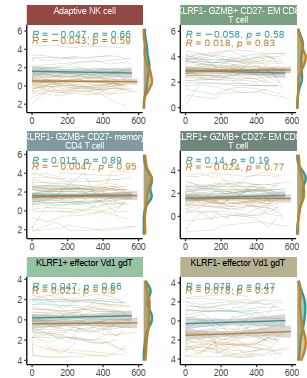

In [46]:
options(repr.plot.width = 65/25.4, repr.plot.height = 80/25.4)
library(cowplot)

plot_list <- lapply(plot_list, function(p) 
  p + theme(plot.margin = unit(c(0, 0,-10,0), "pt"))
)


aligned <- align_plots(plotlist = plot_list, align = "v", axis = "b")

final_plot <- plot_grid(
  plotlist   = aligned,
  ncol       = 2,
  rel_heights = rep(1, length(aligned))  
)

final_plot
ggsave('FigureC.pdf', final_plot, width = 65/25.4, height = 80/25.4)